In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

#  Load Winding Dataset

Industrial Winding Process is a snapshot of a process where a plastic web is unwound from a first reel (unwinding reel), goes over the second traction reel and is finally rewound on the the third rewinding reel. The recordings correspond to the traction of the second reel angular speed. The data contains $2.500$ points sampled at $0.1s$, corresponding to $250s$.

### References 
- [1] https://homes.esat.kuleuven.be/~tokka/daisydata.html
- [2] https://grammarviz2.github.io/grammarviz2_site/morea/motif/experience-m1.html

Dataset Original Length n:  2499
Dataset Sampled Length n:  2499


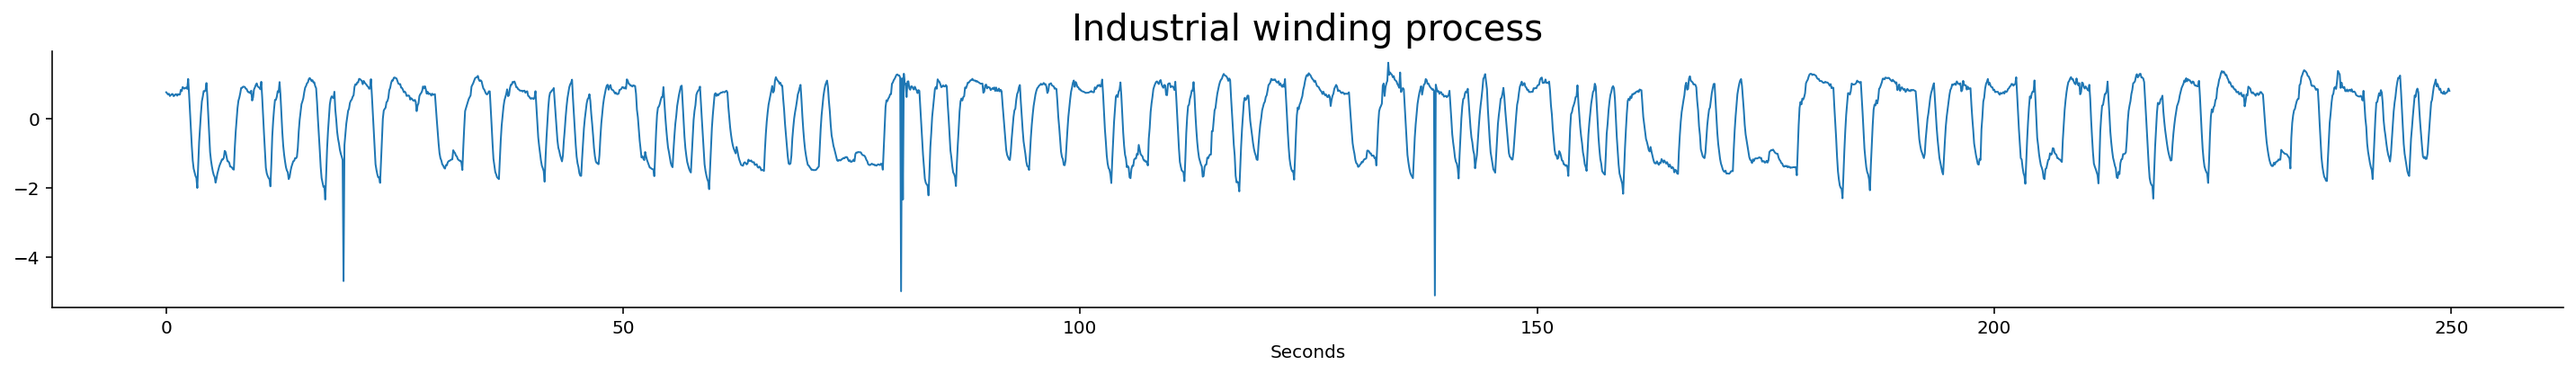

In [2]:
file = "winding_col.csv"
ds_name = "Industrial winding process"
series = ml.read_dataset_with_index(file) 
data = series.values
#series = ml.as_series(data, np.arange(0, len(data), 1) / 10, 'Seconds')
plot_dataset(file, series, ds_name=ds_name)

# Known Motifs

 No documented motifs exist.

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2

rerun_all_jars = False
ks=12
dataset = os.getcwd() + '/../datasets/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets_paper/notebooks/../datasets/winding_col.csv


## First, we learn the motif length l

We find aminimum around $l=6s$, equal to 60 data points.

Compute ks: 100%|███████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 127.32it/s]


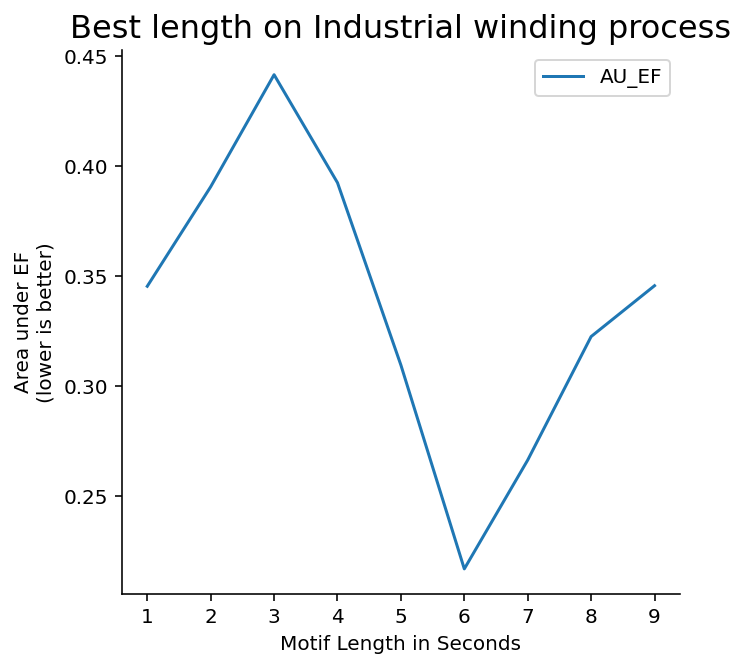

Found motif length 6.0


In [4]:
length_range = np.arange(10,100,10) 
motif_length = plot_motif_length_selection(
    ks, series, file, length_range, ds_name=ds_name)

print ("Found motif length", series.index[motif_length])


## Next, we learn the size k of the motif set

We plot the similarity of the motifs as a function of the cardinality of $k$-Motiflets to their extent. Elbow points represent large changes in similarity of the found motif set, indicative of a concept change from calibrations signal to heartbeats.

Compute ks: 100%|████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 61.21it/s]


Chosen window-size: 60
Elbow Points [ 6 10]


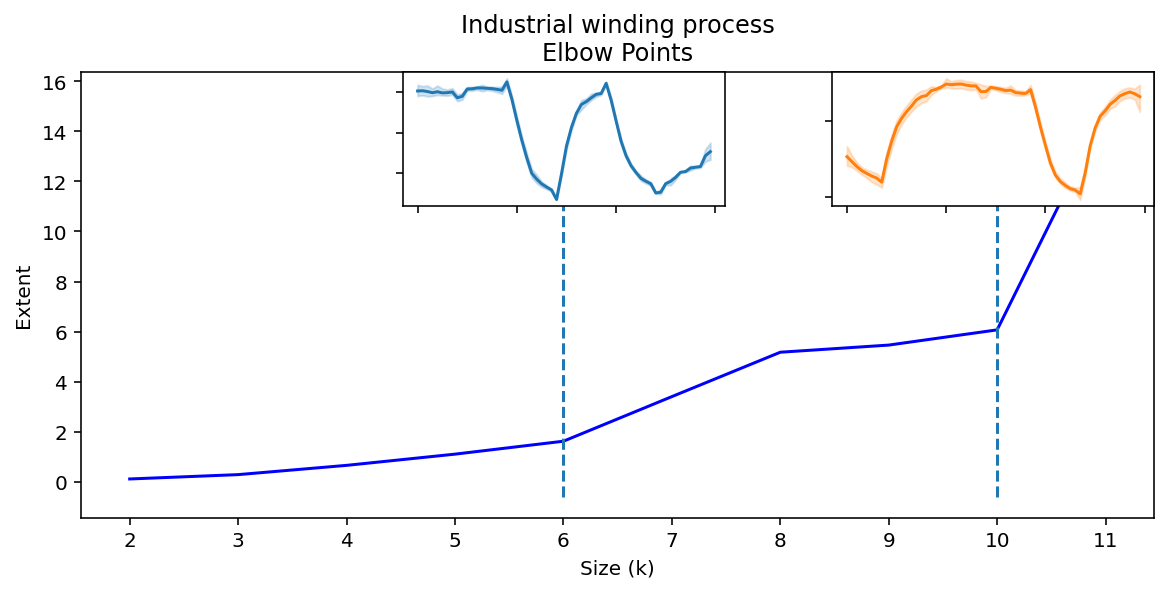

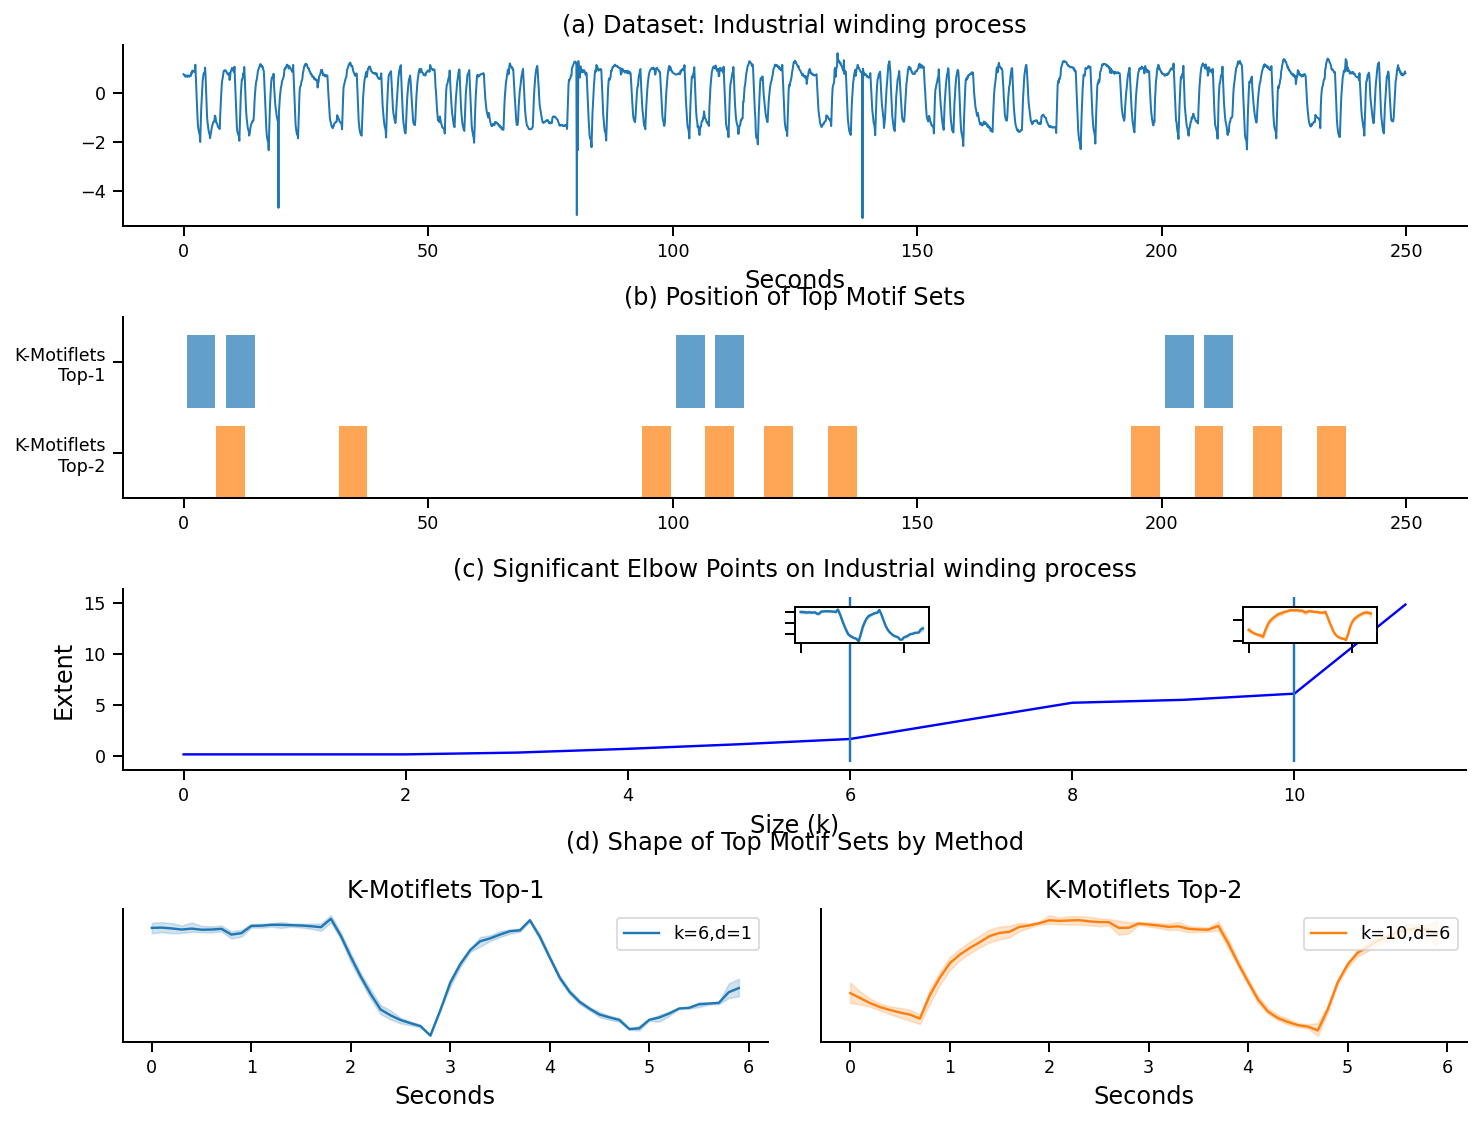

In [5]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, file, ds_name=ds_name, plot_elbows=True,
    motif_length=motif_length, method_name="K-Motiflets")

k-Motiflets found 2 top motifs. The TOP-1 motif occurs in pairs and k=6 occurences. It is interleaved with the TOP-2 motif with 10 occurences.

# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error. 

We use the results of $k$-Motiflets as silver standard and compare the ability of the other methods to recover the respective motifs. To enable such a comparison, we provided the competitors with proper values of $r$ and $l$, derived from the silver standard.

In [6]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]

r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])
print("Radius r of TOP-2 Motifs", r_top1, r_top2)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

radii = np.array([r_top2, r_top1])
print("Radii r", radii)

Radius r of TOP-2 Motifs 4.324788570404053 0.9148634672164917
Extent d of TOP-1 Motif 6.073066234588623
Radii r [0.91486347 4.32478857]


# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [7]:
rs = np.array([r_top2*3, r_top1*2])
mls = motif_length

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/set_finder.jar',
       dataset,
       'SetFinder',
       str(list(rs)),
       str(mls)])

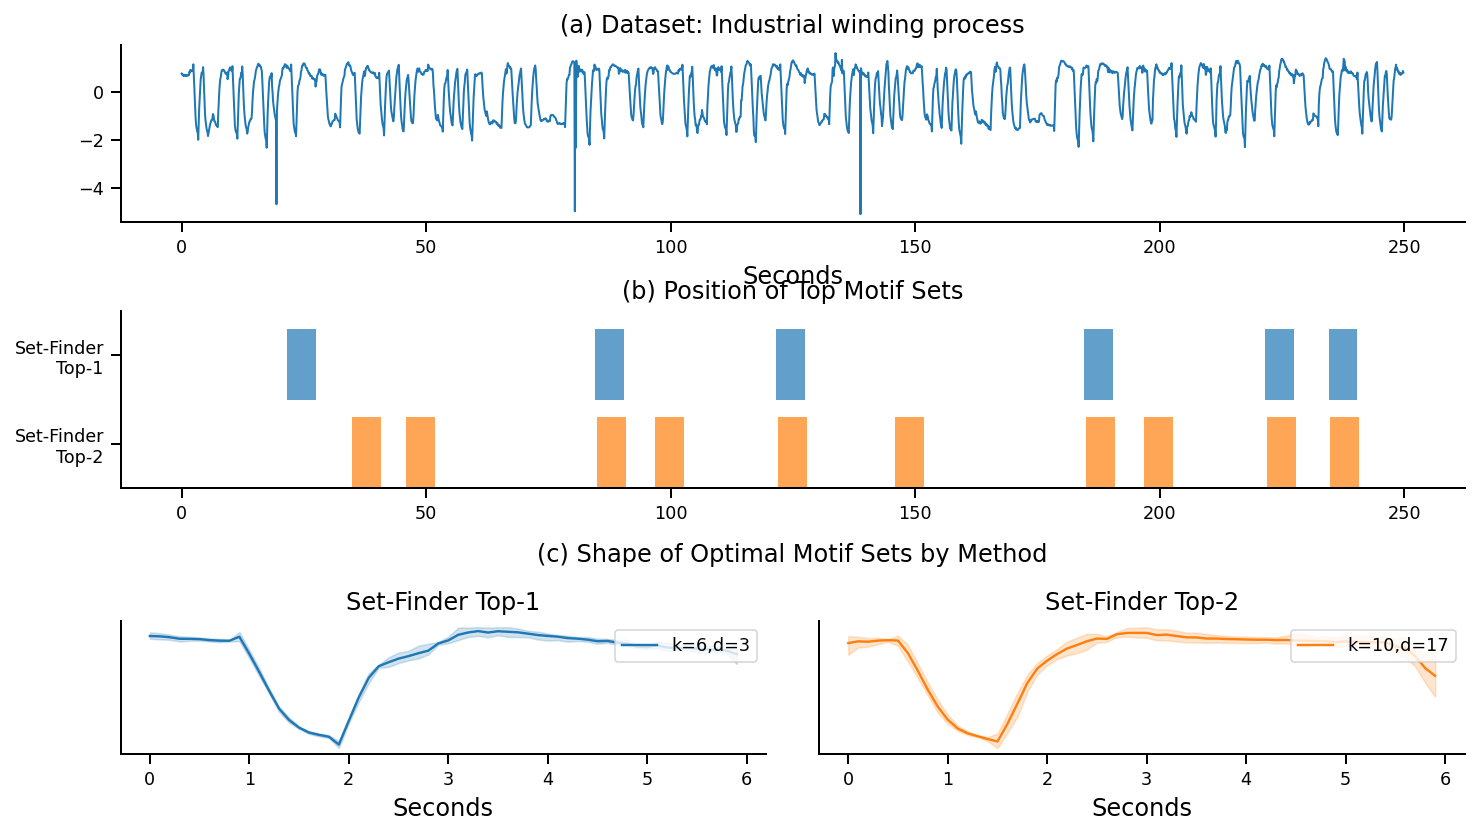

In [8]:
# run jave code first       
ms_set_finder = [
    [215, 845, 1215, 1845, 2215, 2345],
	[349, 459, 849, 968, 1219, 1459, 1849, 1968, 2219, 2348],
]

motifset = plot_competitors(series, ds_name, ms_set_finder, motif_length, 
                            filter=False, prefix="Set-Finder")

df["Set Finder Top-1"] = [motifset[-1]]
df2["Set Finder Top-2"] = [motifset[-2]]

SF found the same motif as TOP-1 and TOP-2.

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [9]:
rs = np.array([r_top2*4, r_top1*6.5956])
mls = motif_length

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/emma.jar',
       dataset,
       str(list(rs)),
       str(mls)])

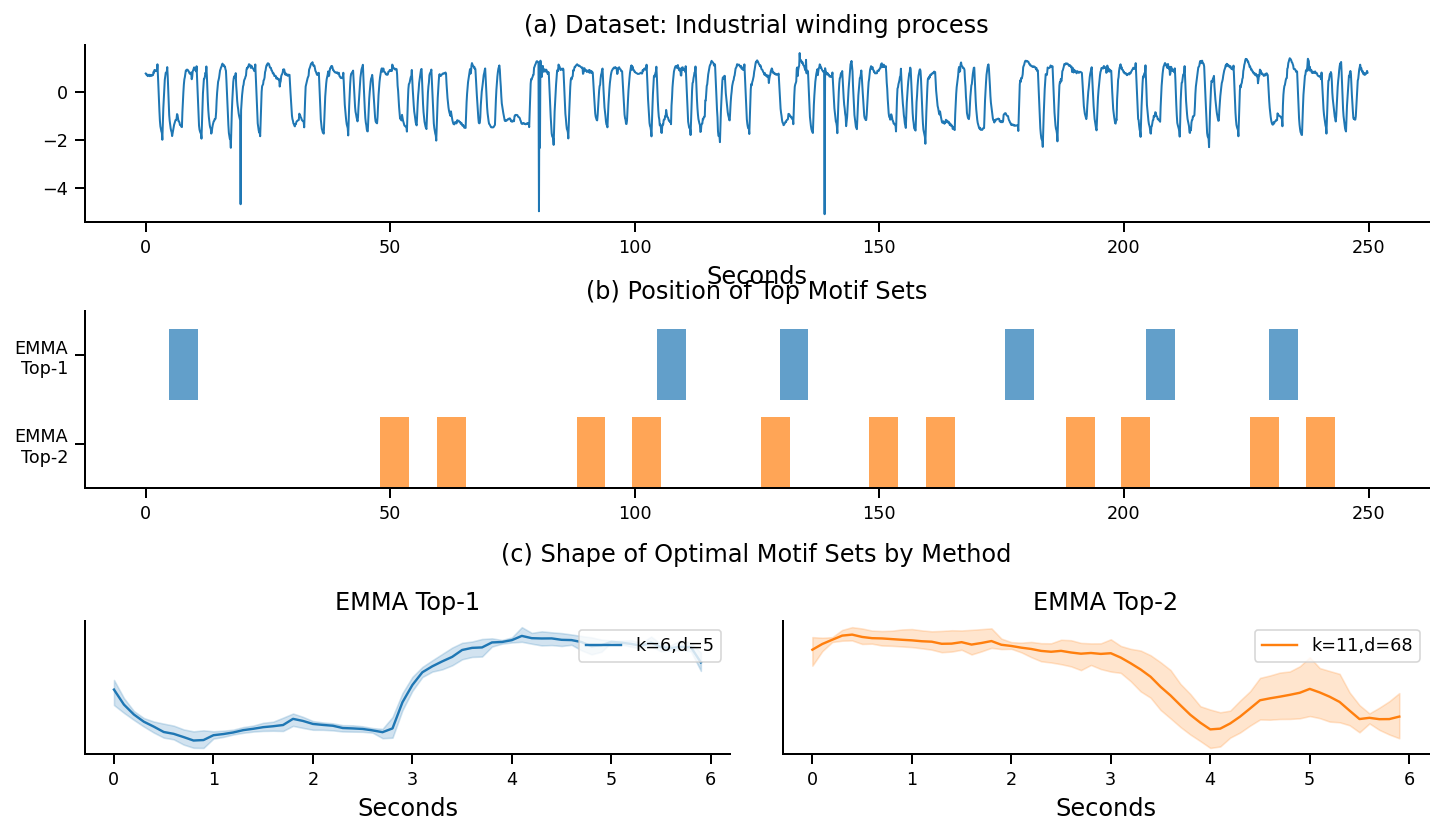

In [10]:
# run jave code first       
ms_emma = [
	[47, 1046, 1296, 1757, 2046, 2296],
	[479, 596, 881, 994, 1258, 1479, 1596, 1881, 1994, 2258, 2373],
]

motifset = plot_competitors(series, ds_name, ms_emma, motif_length, prefix="EMMA")

df["EMMA Top-1"] = [motifset[-1]]
df2["EMMA Top-2"] = [motifset[-2]]



EMMA found a different TOP-1 motif with 6 occurences and a totally blurred TOP-2 motif.

# Valmod Motif Sets
based on own (fixed-length) implementation

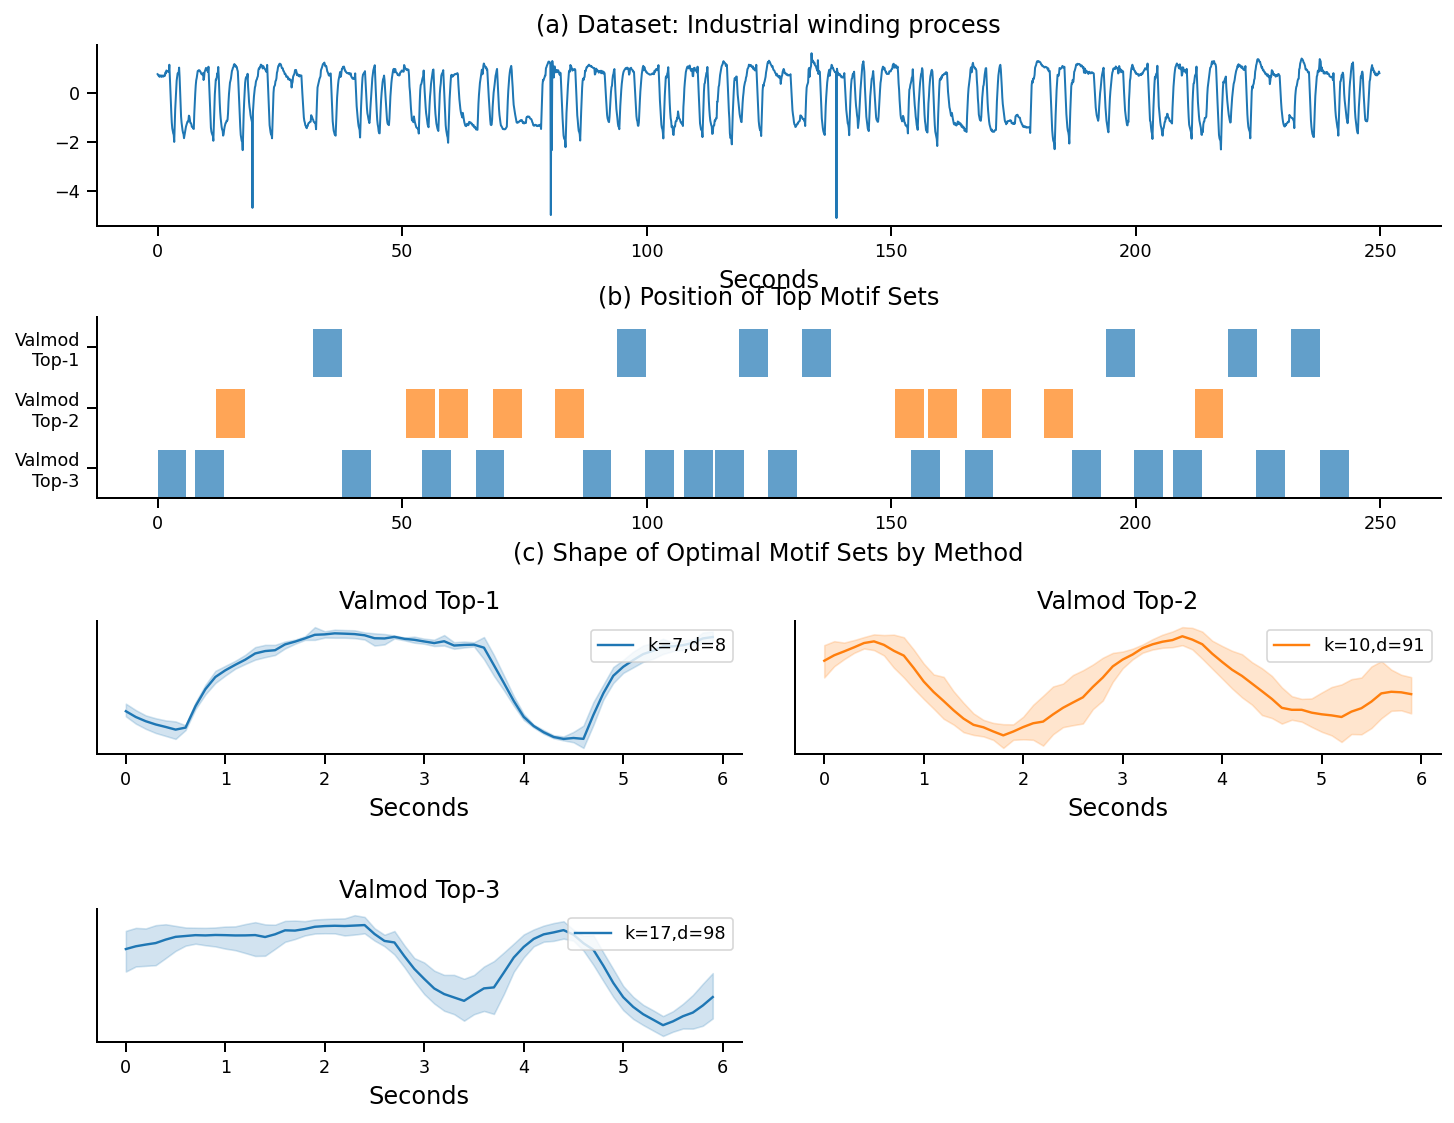

In [11]:
ms_valmod = list(get_valmod_motif_set_ranged(data, file, mls, max_r=r_top1*10))
motifset = plot_competitors(series, ds_name, ms_valmod, 
                            mls, prefix="Valmod", filter=True)

df["VALMOD Top-1"] = [motifset[-2]]
df2["VALMOD Top-2"] = [motifset[-3]]

VALMOD finds the same motif as the TOP-1 by k-motifs and two otherwise blurred motifs.

# Learning Motifs
See Java Code

In [12]:
rs = np.array([r_top2*2, r_top1*2.2])
mls = motif_length

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/latent_motifs.jar',
       dataset,
       str(list(rs+1)),
       str(mls)])

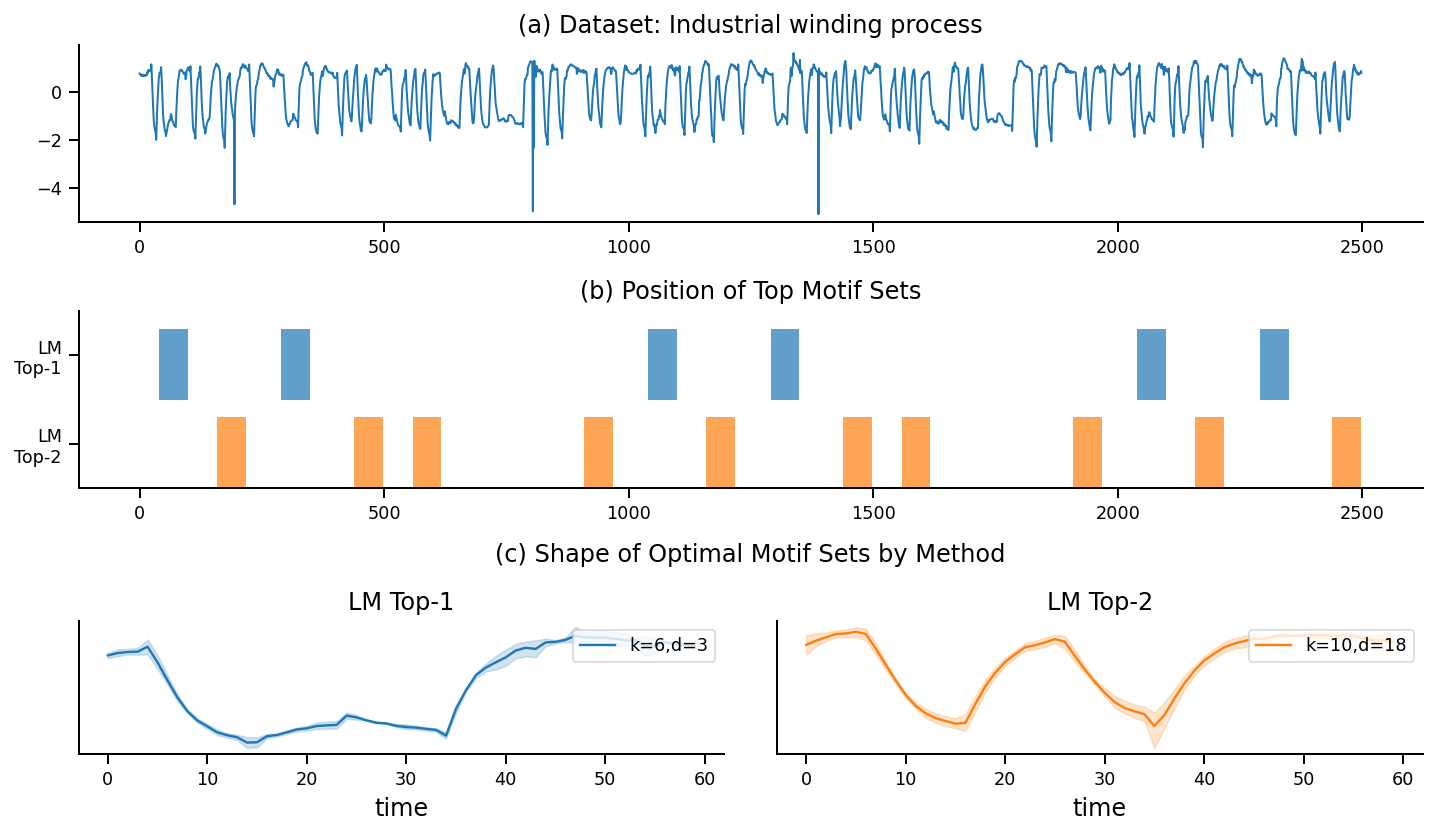

In [13]:
ms_learning_motifs = np.array([
	[40,290,1040,1290,2040,2290,],
	[159,438,558,908,1158,1438,1558,1908,2158,2438,],
])

    
motifset = plot_competitors(data, ds_name, ms_learning_motifs, motif_length, prefix="LM")

df["LM Top-1"] = [motifset[-1]]
df2["LM Top-2"] = [motifset[-2]]


# Comparison

In [14]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
df_all

,offsets
Motiflets Top-1,"[67, 1067, 2067, 317, 937, 1317, 1937, 2317, 2..."
Set Finder Top-1,"[349, 459, 849, 968, 1219, 1459, 1849, 1968, 2..."
EMMA Top-1,"[479, 596, 881, 994, 1258, 1479, 1596, 1881, 1..."
VALMOD Top-1,"[119, 508, 576, 686, 812, 1508, 1576, 1686, 18..."
LM Top-1,"[159, 438, 558, 908, 1158, 1438, 1558, 1908, 2..."
Motiflets Top-2,"[6, 1006, 2006, 86, 1086, 2086]"
Set Finder Top-2,"[215, 845, 1215, 1845, 2215, 2345]"
EMMA Top-2,"[47, 1046, 1296, 1757, 2046, 2296]"
VALMOD Top-2,"[318, 939, 1188, 1318, 1939, 2188, 2318]"
LM Top-2,"[40, 290, 1040, 1290, 2040, 2290]"


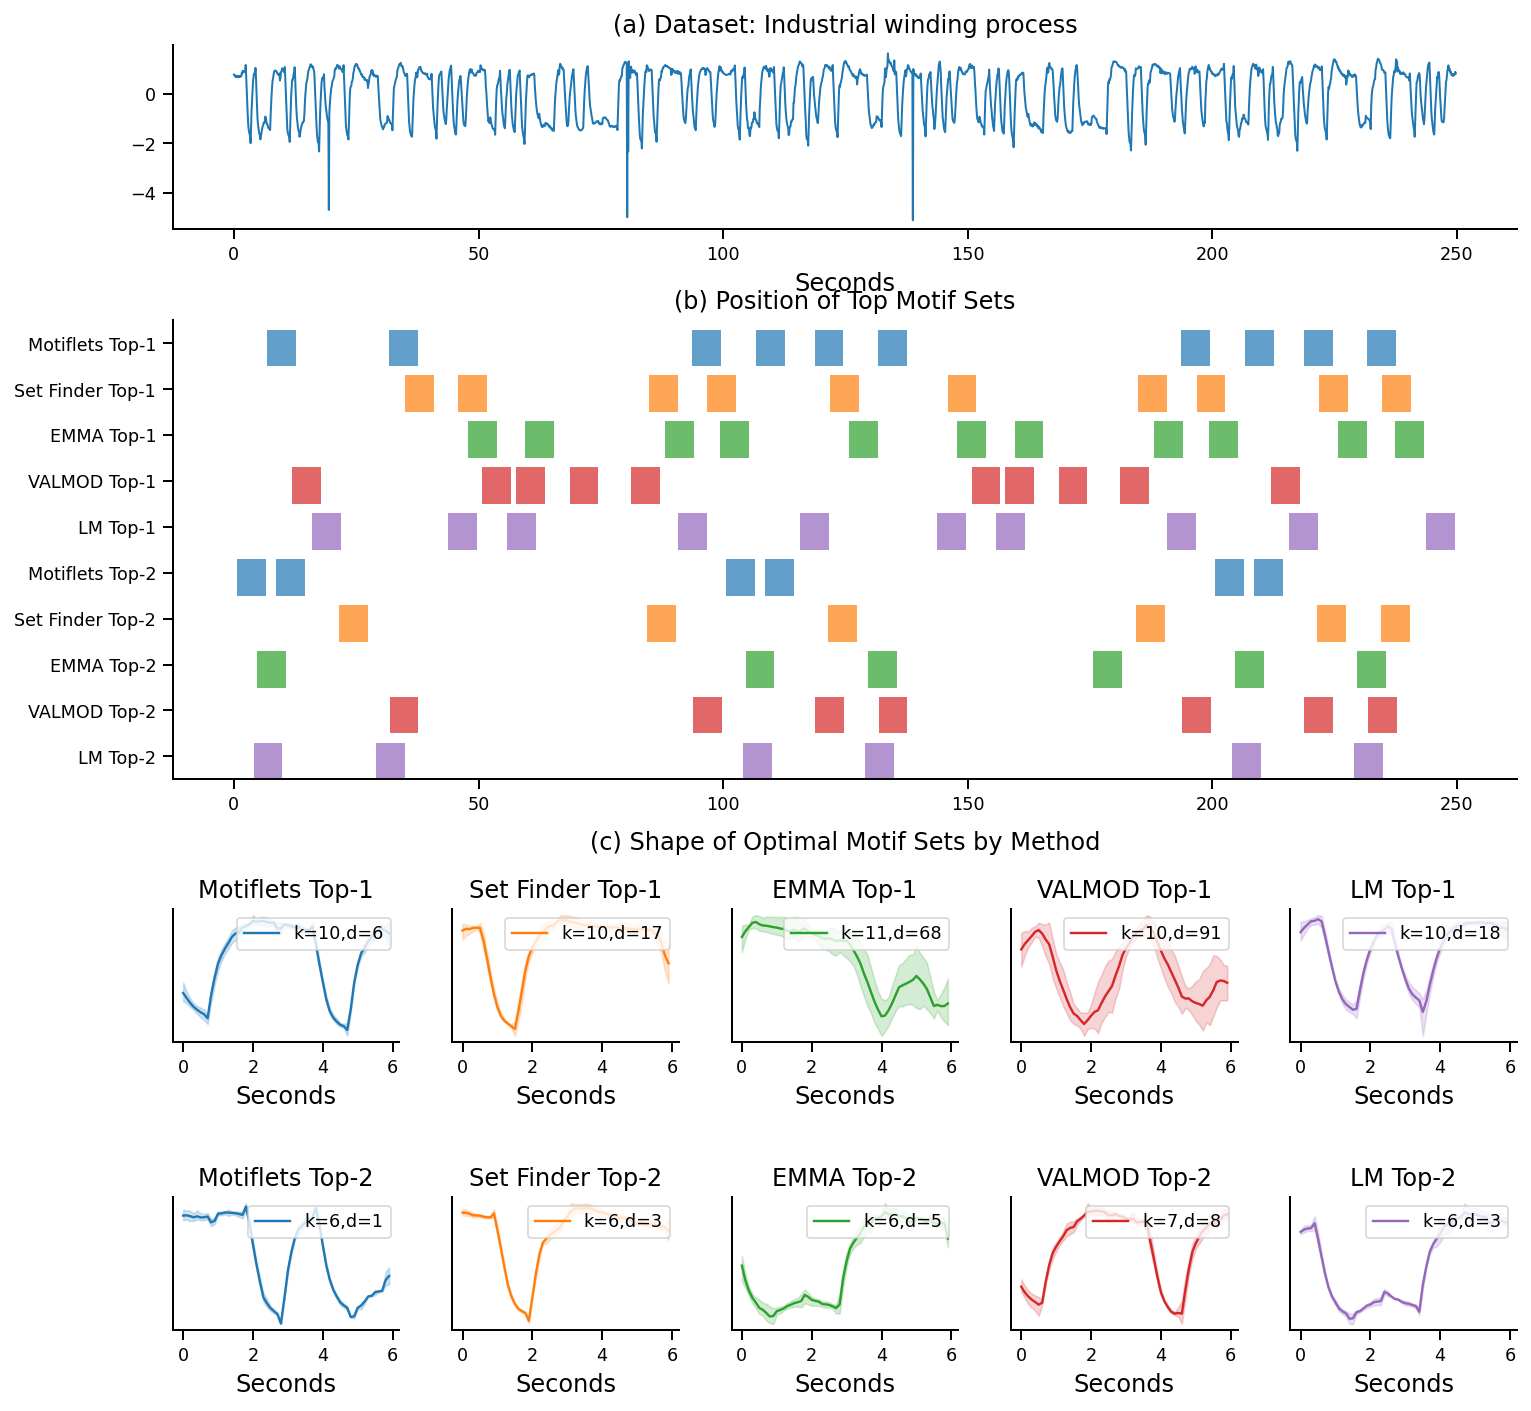

In [15]:
motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_all.index.values)

Results are very difficult to interprete, as no ground truth is available.